# **Data Cleaning Notebook**

## Objectives

* Fetch Data from Kaggle and save as raw file and unzip.
* Inspect the data and save it under inputs/datasets/raw
* Inspect the data and save it under outputs/datasets/collection

## Inputs

* Kaggle JSON file - the authentication token.

## Outputs

* Generate Dataset: outputs/datasets/collection/trimmed_covid_dataset.csv

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-covid-19-study/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-covid-19-study'

---

## Load Collected Data

In [4]:
import pandas as pd
df_raw_path = "outputs/datasets/collection/covid-19-dataset.csv"
df = pd.read_csv(df_raw_path)
print(df.head(3))

   USMER  MEDICAL_UNIT   SEX INTUBED PNEUMONIA  AGE DIABETES COPD ASTHMA  \
0      2             4  Male      No        No   76       No   No     No   
1      2             6  Male      No       Yes   91      Yes   No     No   
2      2            12  Male      No       Yes   39       No   No     No   

  INMSUPR HIPERTENSION OTHER_DISEASE CARDIOVASCULAR OBESITY RENAL_CHRONIC  \
0      No          Yes           Yes             No      No            No   
1      No          Yes            No             No      No            No   
2      No           No            No             No      No            No   

  TOBACCO  ICU DIED  
0      No   No   No  
1      No   No   No  
2      No  Yes  Yes  


## Data Exploration

Check the distribution and shape of a variable with missing data.

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
print(f"Variables with missing data: {vars_with_missing_data}")

Variables with missing data: []


In [6]:
from ydata_profiling import ProfileReport

if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

There are no variables with missing data


## Correlation and PPS Analysis

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%  75%    max
ppscore  306.0  0.006  0.035  0.0  0.0  0.0  0.0  0.287


* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



/workspace/.pip-modules/lib/python3.8/site-packages/seaborn/matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/workspace/.pip-modules/lib/python3.8/site-packages/seaborn/matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


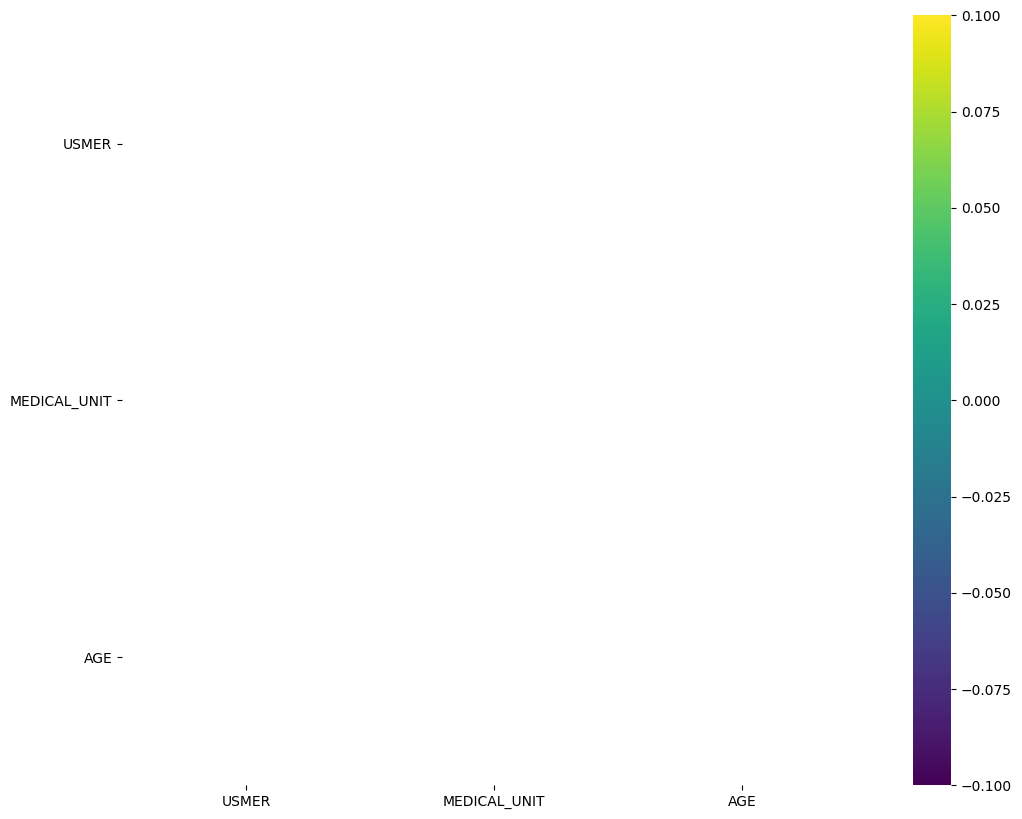



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



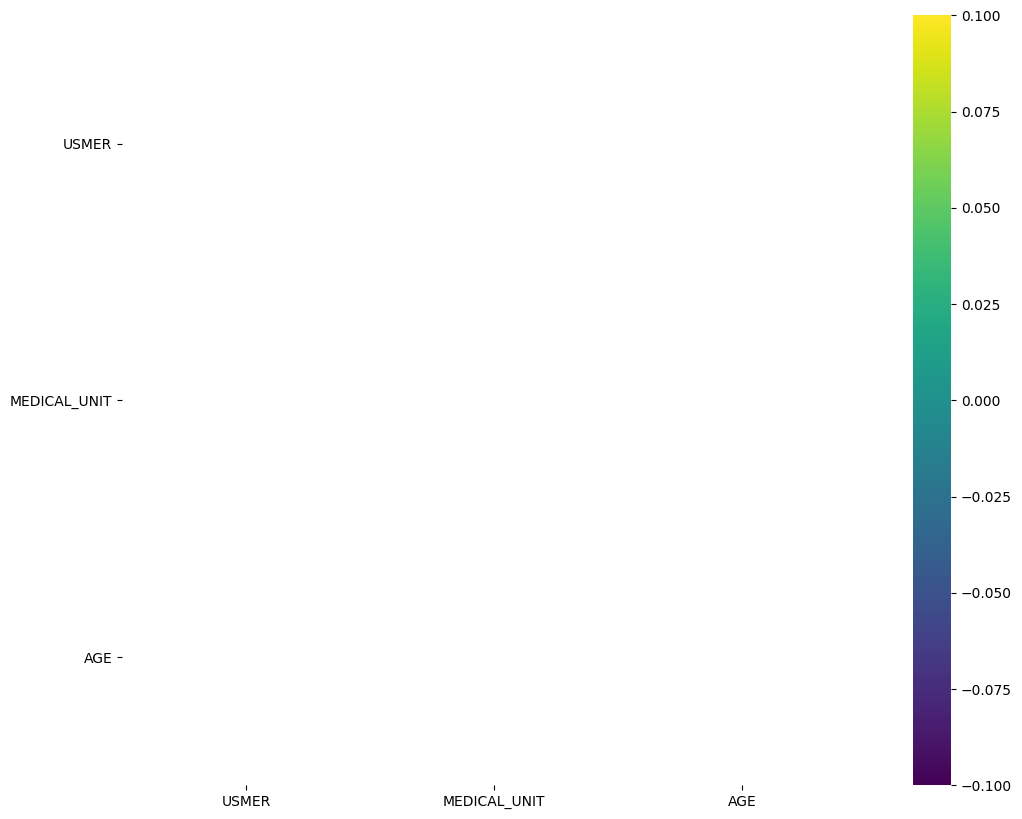



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



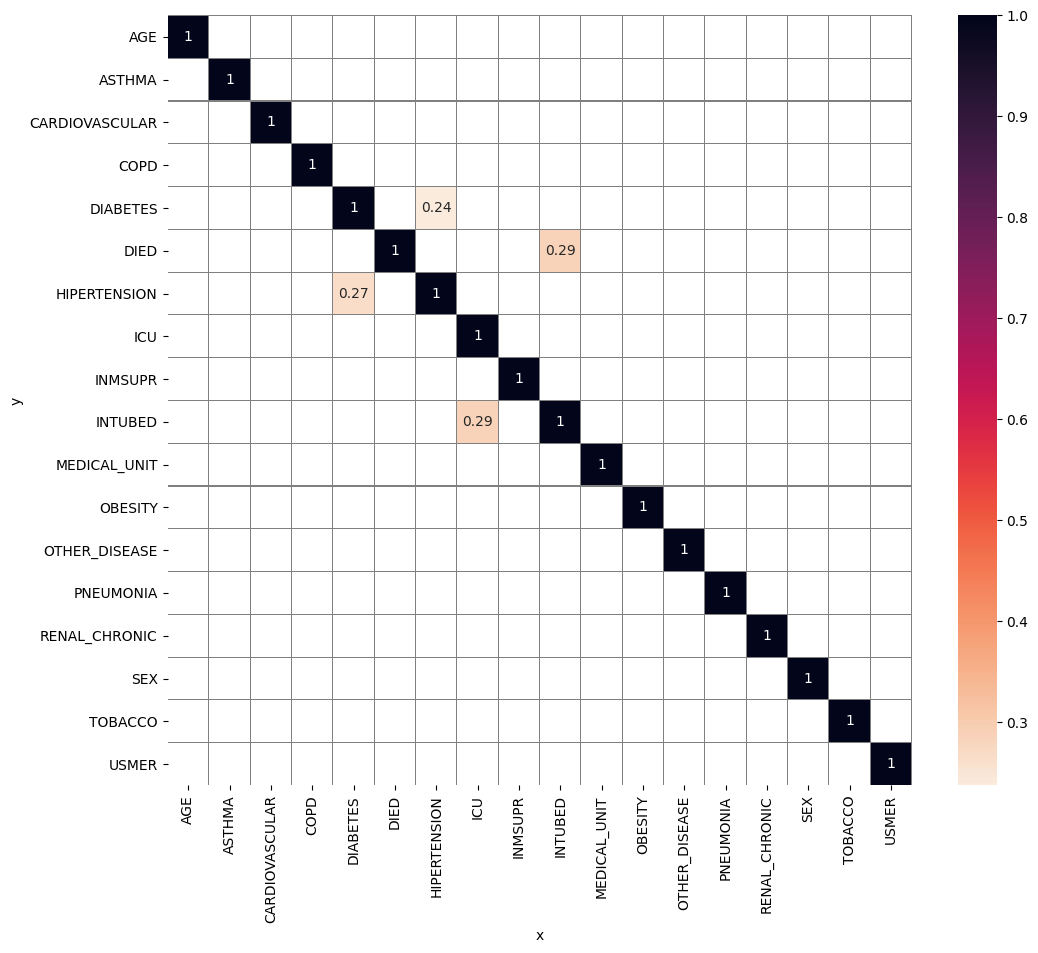

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()

def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()

def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix

def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):
    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)
DisplayCorrAndPPS(df_corr_pearson=df_corr_pearson, df_corr_spearman=df_corr_spearman, pps_matrix=pps_matrix,
                  CorrThreshold=0.4, PPS_Threshold=0.2, figsize=(12, 10), font_annot=10)

## Data Cleaning

### Assessing Missing Data Level

- Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [8]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute / len(df) * 100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                  "PercentageOfDataset": missing_data_percentage,
                                  "DataType": df.dtypes}
                        )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                      )

    return df_missing_data

missing_data_report = EvaluateMissingData(df)
print(missing_data_report)

Empty DataFrame
Columns: [RowsWithMissingData, PercentageOfDataset, DataType]
Index: []


### Data Cleaning Summary

- Variables to drop

In [11]:
variables_method = ['USMER', 'MEDICAL_UNIT']
df_cleaned = df.drop(columns=variables_to_drop)

### Drop features with too many missing values or irrelevant features

In [12]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(df)
df_cleaned = imputer.transform(df)

### Split Train and Test set

In [13]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet = train_test_split(df_cleaned, test_size=0.2, random_state=0)
print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (49788, 16) 
TestSet shape: (12448, 16)


### Re-evaluate missing data in TrainSet

In [15]:
missing_data_report_train = EvaluateMissingData(TrainSet)
print(f"* There are {missing_data_report_train.shape[0]} variables with missing data \n")
print(missing_data_report_train)

* There are 0 variables with missing data 

Empty DataFrame
Columns: [RowsWithMissingData, PercentageOfDataset, DataType]
Index: []


---

## Push cleaned data to Repo

In [16]:
try:
    os.makedirs(name='outputs/datasets/cleaned') 
except Exception as e:
    print(e)

### Train Set

In [17]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

### Test Set

In [18]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)